In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Charge and Exploration of the Dataset

In [2]:
def load_data(file_path):
    """
    Loads the data from a CSV file and performs an initial exploration.
    
    Args:
    file_path (str): Path to the CSV file containing the data.
    
    Returns:
    pd.DataFrame: DataFrame with the loaded data.
    """
    data = pd.read_csv(file_path)
    print("Dataset dimensions:", data.shape)
    print("\nFirst 5 rows of the dataset:")
    print(data.head())
    print("\nDataset information:")
    print(data.info())
    print("\nDescriptive statistics:")
    print(data.describe())
    return data

## Reading genome.csv

In [4]:
data = load_data('.\genome.csv')

C:\Users\JERON\AppData\Local\Temp\ipykernel_6092\3407082076.py:11: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Dataset dimensions: (966977, 4)

First 5 rows of the dataset:
         rsid chromosome  position genotype
0   rs4477212          1     72017       AA
1   rs3094315          1    742429       AA
2   rs3131972          1    742584       GG
3  rs12124819          1    766409       AA
4  rs11240777          1    788822       AG

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966977 entries, 0 to 966976
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   rsid        966977 non-null  object
 1   chromosome  966977 non-null  object
 2   position    966977 non-null  int64 
 3   genotype    966977 non-null  object
dtypes: int64(1), object(3)
memory usage: 29.5+ MB
None

Descriptive statistics:
           position
count  9.669770e+05
mean   7.672147e+07
std    5.640974e+07
min    3.000000e+00
25%    3.012131e+07
50%    6.667251e+07
75%    1.134776e+08
max    2.471856e+08


# Data Preprocesing
## Cleaning the data

In [9]:
def clean_data(data):
  """
  Cleans the data by handling missing values and verifying the distribution.
  
  Args:
  data (pd.DataFrame): Original DataFrame.
  
  Returns:
  pd.DataFrame: Cleaned DataFrame.
  """

  print ("missing values for columns")
  print(data.isnull().sum())

  # Handle missing values
  imputer = SimpleImputer(strategy='most_frequent')#used to replace missing values with the most frequent value in the column
  data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)# data_imputed is a new dataframe with the missing values replaced

  print("\nDistribution of genotypes:")
  print(data_imputed['genotype'].value_counts(normalize=True)) #will get the percentage of each genotype
    
  return data_imputed
data_clean = clean_data(data)


missing values for columns
rsid          0
chromosome    0
position      0
genotype      0
dtype: int64

Distribution of genotypes:
genotype
CC    0.180192
GG    0.179433
TT    0.152389
AA    0.152314
CT    0.119876
AG    0.119552
GT    0.027953
AC    0.027739
C     0.008156
G     0.008005
A     0.007474
T     0.007386
--    0.006541
CG    0.001208
II    0.000754
AT    0.000654
DD    0.000184
I     0.000123
D     0.000048
DI    0.000019
Name: proportion, dtype: float64


## Processing data

In [13]:
def preprocess_data(data):
    """
    Realiza el preprocesamiento de los datos, incluyendo codificación one-hot y escalado.
    
    Args:
    data (pd.DataFrame): DataFrame limpio.
    
    Returns:
    tuple: X_processed (features procesadas), preprocessor (ColumnTransformer)
    """
    print("Iniciando preprocesamiento...")
    print("Columnas en el DataFrame:", data.columns)
    print("Tipos de datos:")
    print(data.dtypes)
    
    # Crear preprocesador
    numeric_features = ['chromosome', 'position']
    categorical_features = ['genotype']
    
    print("Características numéricas:", numeric_features)
    print("Características categóricas:", categorical_features)
    
    # Convertir 'chromosome' y 'position' a tipo numérico si no lo son
    data['chromosome'] = pd.to_numeric(data['chromosome'], errors='coerce')
    data['position'] = pd.to_numeric(data['position'], errors='coerce')
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    print("Aplicando preprocesamiento...")
    # Ajustar y transformar
    try:
        X_processed = preprocessor.fit_transform(data)
        print("Preprocesamiento completado con éxito.")
    except Exception as e:
        print("Error durante el preprocesamiento:")
        print(str(e))
        raise
    
    print("Obteniendo nombres de características...")
    # Obtener nombres de características después del preprocesamiento
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    feature_names = (numeric_features + 
                     onehot_encoder.get_feature_names_out(categorical_features).tolist())
    
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
    
    print("Dimensiones de X después del preprocesamiento:", X_processed_df.shape)
    print("\nPrimeras 5 filas de X preprocesado:")
    print(X_processed_df.head())
    
    return X_processed_df, preprocessor

# Aplicar
try:
    X_processed, preprocessor = preprocess_data(data_clean)
    print("Preprocesamiento completado exitosamente.")
except Exception as e:
    print("Error al aplicar el preprocesamiento:")
    print(str(e))

Iniciando preprocesamiento...
Columnas en el DataFrame: Index(['rsid', 'chromosome', 'position', 'genotype'], dtype='object')
Tipos de datos:
rsid          object
chromosome    object
position      object
genotype      object
dtype: object
Características numéricas: ['chromosome', 'position']
Características categóricas: ['genotype']
Aplicando preprocesamiento...
Preprocesamiento completado con éxito.
Obteniendo nombres de características...
Dimensiones de X después del preprocesamiento: (966977, 21)

Primeras 5 filas de X preprocesado:
   chromosome  position  genotype_A  genotype_AA  genotype_AC  genotype_AG  \
0   -1.362345 -1.358799         0.0          1.0          0.0          0.0   
1   -1.362345 -1.346914         0.0          1.0          0.0          0.0   
2   -1.362345 -1.346912         0.0          0.0          0.0          0.0   
3   -1.362345 -1.346489         0.0          1.0          0.0          0.0   
4   -1.362345 -1.346092         0.0          0.0          0.0      

# Vizualice data cleaning

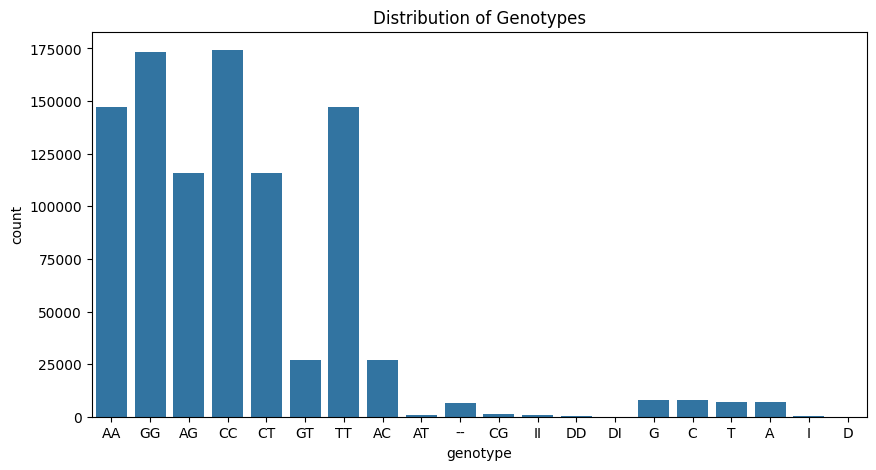

c:\Users\JERON\OneDrive\Documents\Projects\DNA proyect\Backend\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


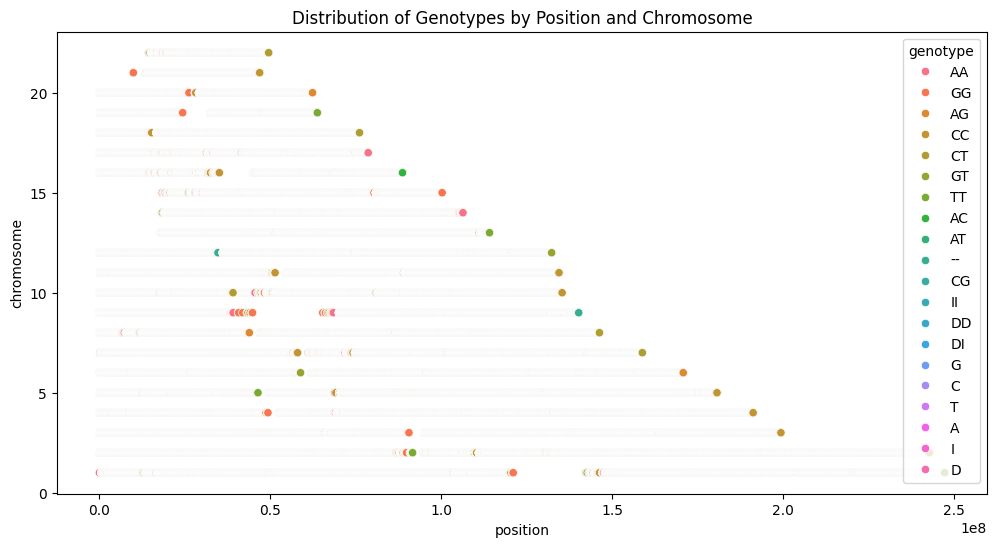

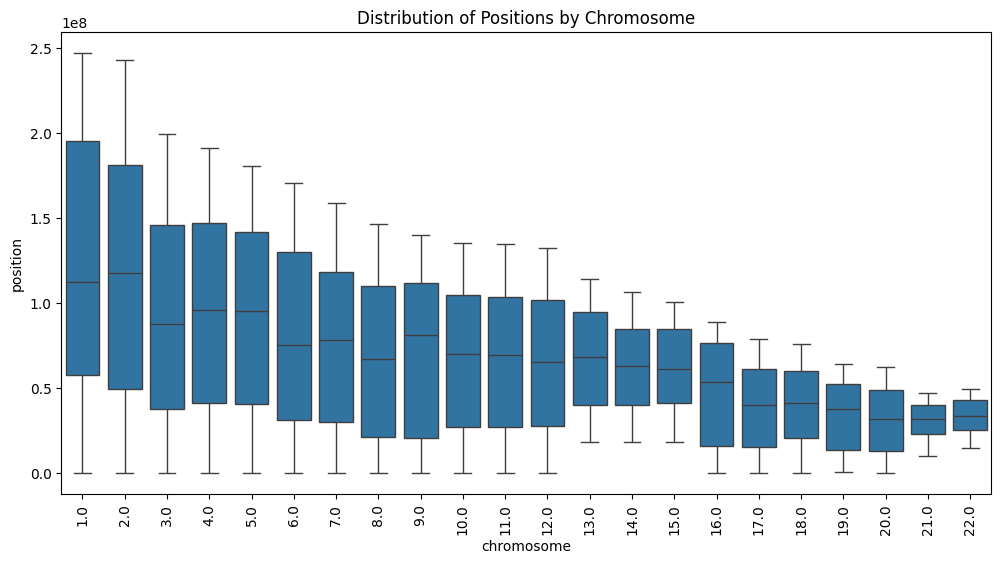

In [16]:
def visualize_data(data):
  """
  Creates visualizations to explore the data.
  
  Args:
  data (pd.DataFrame): Original DataFrame.
  """
  plt.figure(figsize=(10, 5))
  sns.countplot(x='genotype', data=data)
  plt.title('Distribution of Genotypes')
  plt.show()
  
  plt.figure(figsize=(12, 6))
  sns.scatterplot(data=data, x='position', y='chromosome', hue='genotype')
  plt.title('Distribution of Genotypes by Position and Chromosome')
  plt.show()

  plt.figure(figsize=(12, 6))
  sns.boxplot(x='chromosome', y='position', data=data)
  plt.title('Distribution of Positions by Chromosome')
  plt.xticks(rotation=90)
  plt.show()

visualize_data(data_clean)

# Correlation Analisis